[![preview notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PySDM/blob/main/examples/PySDM_examples/Matsushima_et_al_2023/figure_1.ipynb)
[![launch on mybinder.org](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PySDM.git/main?urlpath=lab/tree/examples/PySDM_examples/Matsushima_et_al_2023/figure_1.ipynb)
[![launch on Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PySDM/blob/main/examples/PySDM_examples/Matsushima_et_al_2023/figure_1.ipynb)

[Matsushima 2023 (GMD)](https://doi.org/10.5194/gmd-16-6211-2023)

In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples')

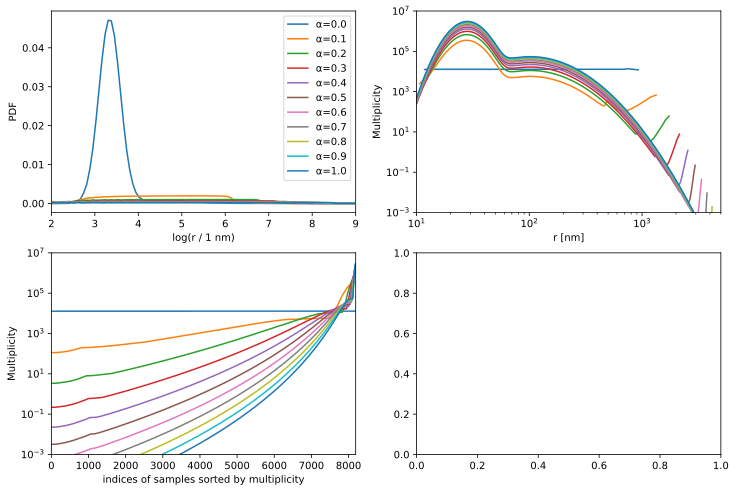

In [10]:
from PySDM import Formulae
from PySDM.physics import si, in_unit
from PySDM.backends import CPU
from PySDM.initialisation.sampling.spectral_sampling import AlphaSamplingPseudoRandom, AlphaSamplingRandom, AlphaSampling
from PySDM.initialisation import spectra
import matplotlib.pyplot as plt
import numpy as np
from open_atmos_jupyter_utils import show_plot
from types import SimpleNamespace


formulae = Formulae()
n_sd = 2**13
mode1 = spectra.Lognormal(
    norm_factor=90 / si.centimetre**3,
    m_mode=0.03 * si.micrometre,
    s_geom=1.28,
)
mode2 = spectra.Lognormal(
    norm_factor=15 / si.centimetre**3,
    m_mode=0.14 * si.micrometre,
    s_geom=1.75,
)
spectrum = spectra.Sum((mode1, mode2))

fig,axs = plt.subplot_mosaic([['a','b'],['c','']], figsize=(12, 8))
alphas = np.linspace(0, 1, 11)
xlim = (2, 9)
size_range = (10 * si.nm, 5000 * si.nm)
backend = CPU
backend=backend(formulae=Formulae())

dist_0 = SimpleNamespace()
dist_1 = SimpleNamespace()
dist_0.cdf =  lambda x: spectrum.cdf(x) # Constant Multiplicity
dist_1.percentiles = lambda y: (size_range[1] - size_range[0]) * y # Uniform Linear

for alpha in alphas:
    sampling = AlphaSampling(spectrum, alpha=alpha, size_range=size_range,dist_0=dist_0,dist_1=dist_1)
    xa, ya = sampling.sample(n_sd,backend=backend)
    a, b = np.histogram(in_unit(xa, si.nm), density=True, bins=np.logspace(*xlim, num=100, base=np.e))
    b = np.log(b)
    axs['a'].plot(b[:-1] + np.diff(b) / 2, a, label=f'α={alpha:.1f}')
    axs['b'].plot(in_unit(xa, si.nm), ya, label=f'α={alpha:.2f}')
    axs['c'].plot(np.sort(ya), label=f'alpha={alpha:.2f}')
axs['a'].legend()
axs['a'].set( 
     ylabel='PDF', 
     xlabel='log(r / 1 nm)',
     xlim=xlim,
     # ylim=(3e5, 0.4e8) - #TODO #1651
)
axs['b'].set(
    xlabel='r [nm]',
    ylabel='Multiplicity',
    xscale='log',
    yscale='log',
    xlim=(10, 5000),
    ylim=(1e-3, 1e7)
)
axs['c'].set(
    xlabel='indices of samples sorted by multiplicity',
    ylabel='Multiplicity',
    yscale='log',
    xlim=(0, n_sd),
    ylim=(1e-3, 1e7)
)
show_plot('fig_1')